In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PolygonPatch
from matplotlib.animation import FuncAnimation, FFMpegWriter
from cylinder import FloatingCylinder
from wavesolver import WaveSolver
from twodubem._internal import tozero

In [2]:
ursell_ws = np.loadtxt('references/ursell_frequencies.csv')
ursell_azn = np.loadtxt('references/ursell_heave_added_mass.csv')
ursell_bzn = np.loadtxt('references/ursell_heave_wave_damping.csv')
ursell_wa = np.loadtxt('references/ursell_wave_rao.csv')

vugts_azn = np.loadtxt('references/vugts_heave_added_mass.csv', delimiter=',')
vugts_bzn = np.loadtxt('references/vugts_heave_wave_damping.csv', delimiter=',')
vugts_wa = np.loadtxt('references/vugts_wave_rao.csv', delimiter=',')
vugts_fzn = np.loadtxt('references/vugts_heave_force.csv', delimiter=',')

In [3]:
number_of_elements = 10
FC = FloatingCylinder(1.0, number_of_elements)

# Parameters
rho = 1.0               # Water density
g = 9.81                # Acceleration of gravity
R = 1.0                 # Cylinder radius
A = 0.5 * np.pi * R**2  # Cylinder wetted volume/length
M = rho * A             # Cylinder mass/length
cz = 2*R * rho * g      # Restoring coefficient in heave.

# Frequencies. Interval between frequencies
# is smaller around the irregular frequency.
wv1 = np.linspace(0.25, 4.0, 20, endpoint=False)
wv2 = np.linspace(4.0, 4.5, 20, endpoint=False)
wv3 = np.linspace(4.5, 5.0, 5)
wv = np.concatenate((wv1, wv2, wv3))
ws = wv * np.sqrt(R / g)  # Dimensionless frequencies

In [4]:
az = np.empty_like(wv)                       # Heave Added mass
bz = np.empty_like(wv)                       # Heave Wave damping
wa = np.empty_like(wv)                       # Wave RAO
fz = np.empty_like(wv, dtype=np.complex128)  # Force in heave (Froud-Krylov + diffraction)

for i, w in enumerate(wv):
    solver = WaveSolver(FC, w)
    solver.solve_radiation_problem()
    solver.solve_diffraction_problem()

    az[i], bz[i] = solver.get_radiation_coefficients()
    wa[i] = solver.get_wave_amplitude()
    fz[i] = solver.get_forces()


# Dimensionless radiation coefficients.
azn = az / M
bzn = bz * np.sqrt(R/g) / M

# Dimensionless force
fzn = np.abs(fz) / cz

# By Haskind relation, we obtain the analytical
# force in heave from the analytical wave damping.
ursell_fzn = np.sqrt(rho*g**2/ursell_ws * M*ursell_bzn) / cz

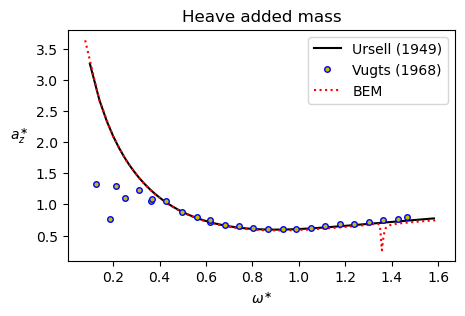

In [5]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_title('Heave added mass')
ax.set_xlabel(r'$\omega^{\ast}$')
ax.set_ylabel(r'$a^{\ast}_z$', rotation=0, labelpad=12)

ax.plot(ursell_ws, ursell_azn, '-k', label='Ursell (1949)')
ax.plot(ws, azn, ':r', label='BEM')
ax.plot(vugts_azn[:, 0], vugts_azn[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Vugts (1968)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax.legend(by_label.values(), by_label.keys())

plt.savefig('heave_added_mass.svg', bbox_inches='tight')
plt.show()

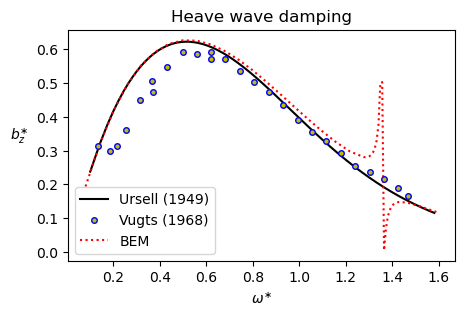

In [6]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_title('Heave wave damping')
ax.set_xlabel(r'$\omega^{\ast}$')
ax.set_ylabel(r'$b^{\ast}_z$', rotation=0, labelpad=12)

ax.plot(ursell_ws, ursell_bzn, '-k', label='Ursell (1949)')
ax.plot(ws, bzn, ':r', label='BEM')
ax.plot(vugts_bzn[:, 0], vugts_bzn[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Vugts (1968)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax.legend(by_label.values(), by_label.keys())

plt.savefig('heave_wave_damping.svg', bbox_inches='tight')
plt.show()

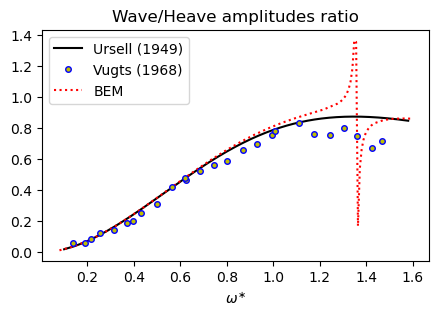

In [7]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_title('Wave/Heave amplitudes ratio')
ax.set_xlabel(r'$\omega^{\ast}$')

ax.plot(ursell_ws, ursell_wa, '-k', label='Ursell (1949)')
ax.plot(ws, wa, ':r', label='BEM')
ax.plot(vugts_wa[:, 0], vugts_wa[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Vugts (1968)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax.legend(by_label.values(), by_label.keys())

plt.savefig('wave_rao.svg', bbox_inches='tight')
plt.show()

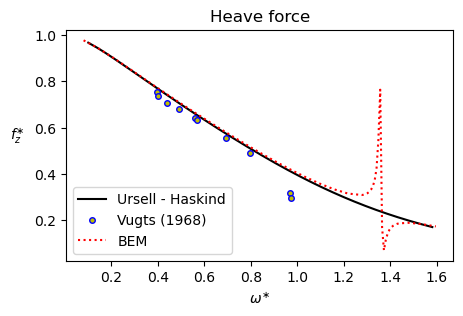

In [8]:
fig, ax = plt.subplots(figsize=(5,3))

ax.set_title('Heave force')
ax.set_xlabel(r'$\omega^{\ast}$')
ax.set_ylabel(r'$f^{\ast}_z$', rotation=0, labelpad=12)

ax.plot(ursell_ws, ursell_fzn, '-k', label='Ursell - Haskind')
ax.plot(ws, fzn , ':r', label='BEM')
ax.plot(vugts_fzn[:, 0], vugts_fzn[:, 1], 'o', mfc='y', ms=4, mec='b', mew=1, label='Vugts (1968)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(
    [labels[0], labels[2], labels[1]],
    [handles[0], handles[2], handles[1]]
))
ax.legend(by_label.values(), by_label.keys())

plt.savefig('heave_force.svg', bbox_inches='tight')
plt.show()

In [9]:
zres = fz / (-wv**2*(M+az) - 1j*bz*wv + cz)
zrao = np.abs(zres)
zeps = np.atan2(zres.imag, zres.real)

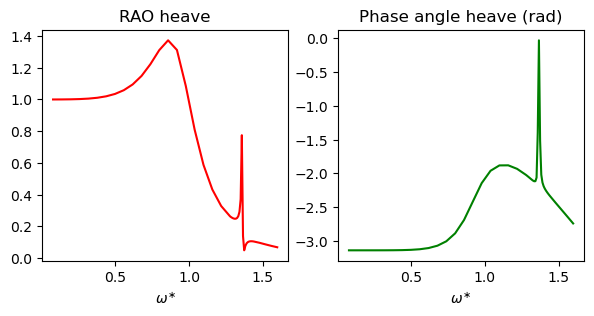

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

ax[0].set_title('RAO heave')
ax[0].plot(ws, zrao, '-r')
ax[0].set_xlabel(r'$\omega^{\ast}$')

ax[1].set_title('Phase angle heave (rad)')
ax[1].plot(ws, zeps, '-g')
ax[1].set_xlabel(r'$\omega^{\ast}$')

plt.savefig('heave_RAO.svg', bbox_inches='tight')
plt.show()

In [11]:
# We are going to use the frequency where the RAO in heave is
# maximum to create an animation for our floating cylinder.
# Another animation will be created for the low RAO region, but
# not on the irregular frequency region.
wm_index = np.where(zrao == zrao.max())[0][0]
# wm_index = 19  # Low RAO region.
wm = wv[wm_index]
Tm = 2*np.pi/wm
aw = 0.10                 # Wave amplitude.
az = zres[wm_index] * aw  # Heave amplitude.
t = np.linspace(0.0, 5*Tm, 100)
et = np.exp(1j * wm * t)

solver = WaveSolver(FC, wm)
solver.solve_radiation_problem()
solver.solve_diffraction_problem()

fsp = np.linspace([-5*R, 0.0], [5*R, 0.0], 70)

phir, phid, gradphir, gradphid = solver.get_potentials(fsp[:, 0], fsp[:, 1])
phii, gradphii = solver.incident_wave_potential(fsp[:, 0], fsp[:, 1], wm, g)

fsz = 1j*(az*phir + aw*(phid+phii))*wm/g

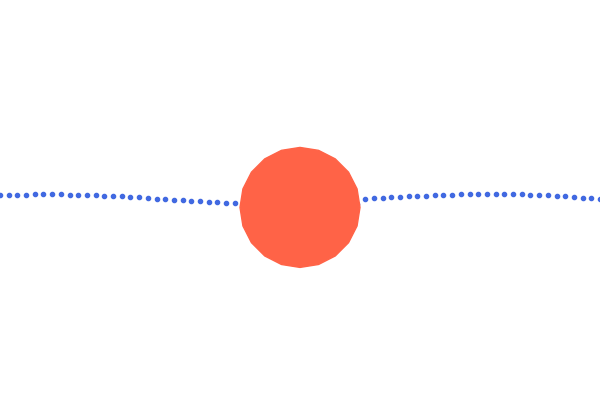

In [12]:
%matplotlib ipympl

def wave_cylinder(time_step):
    # update free surface.
    free_surface.set_ydata(np.real(fsz * et[time_step]))

    # update cylinder.
    vertices = cylinder_vertices.copy()
    vertices[:, 1] += np.real(aw * zres[wm_index] * et[time_step])
    cylinder.set_xy(vertices)


# Cylinder vertices.
theta = np.linspace(0.0, 2*np.pi, 2*number_of_elements + 1)
cylinder_vertices = tozero(np.column_stack((R * np.cos(theta), R * np.sin(theta))))

fig, ax = plt.subplots(figsize=(6,4), frameon=False)

# Parameters for framing the animation.
xmax = 5*R
ymax = 2*R
xmin = -xmax
ymin = -ymax

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

ax.spines[:].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_aspect('equal')

# Initialization.
free_surface = ax.plot(fsp[:, 0], np.real(fsz * et[0]), ls='', marker='.', color='royalblue')[0]

vertices = cylinder_vertices.copy()
vertices[:, 1] += aw * np.real(zres[wm_index] * et[0])
cpatch = PolygonPatch(vertices, color='tomato', zorder=3)
cylinder = ax.add_patch(cpatch)

anim = FuncAnimation(fig, wave_cylinder, frames=range(1, len(t)), interval=100, blit=True)

# Saving to video.
fig.tight_layout(pad=0)
metadata = dict(title='floating_cylinder', artist='Rodrigo Castro')
writer = FFMpegWriter(fps=10, metadata=metadata)
anim.save('cylinder.gif', writer=writer)

plt.show()